# SVM Classification

## Load Dataset

In [2]:
# Load dataset
from sklearn.datasets import load_breast_cancer
from sklearn.naive_bayes import MultinomialNB

cancer = load_breast_cancer() # 이진분류를 위한 데이터셋을 새로 로드

data = cancer["data"] # 실제 데이터 (모델 인풋, X)
target = cancer["target"] # 예측 값 (실제 아웃풋, Y)
feature_name = cancer["feature_names"]



## Data Analysis

In [3]:
!pip3 install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
print(feature_name) # 어떤 피쳐가 있는지 확인하기

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [6]:
feature_use = ['mean radius', 'mean texture', 'mean perimeter', 'mean area']
data_for_analysis = data[:, :4] #일부 데이터만을 활용하여 데이터 분석
df = pd.DataFrame(data_for_analysis)
df.columns = feature_use
df["target"] = target

Text(0.5, 1.0, 'The number of the each label')

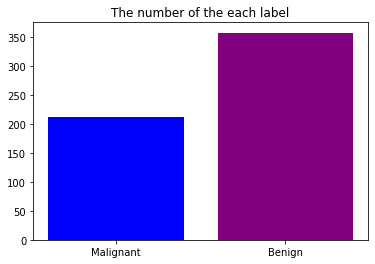

In [7]:
count_label = np.bincount(df.target)
label_name = ["Malignant", "Benign"]
plt.bar(label_name, count_label, color=["blue", "purple"])
plt.title("The number of the each label")

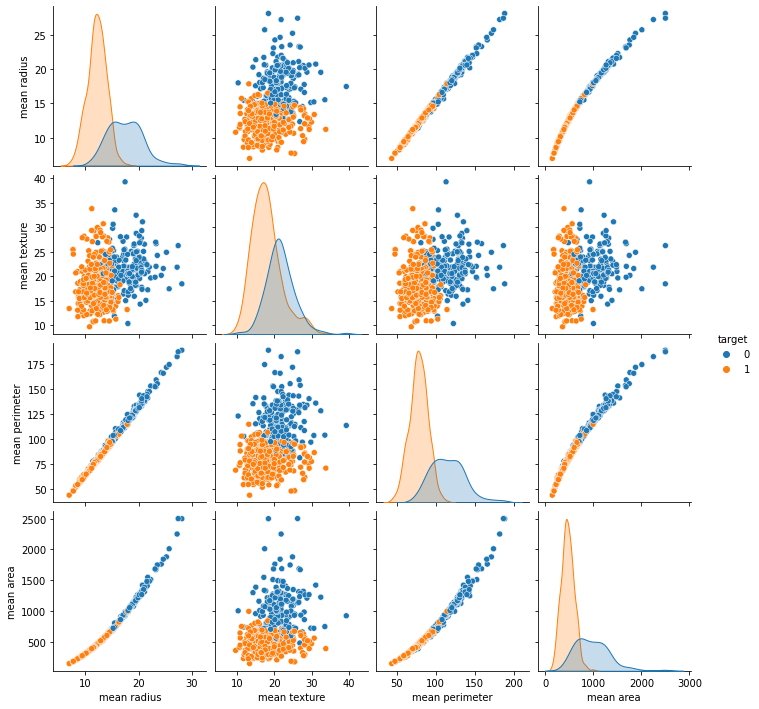

In [8]:


sns.pairplot(df,hue="target", vars=feature_use)

Text(0.5, 1.0, 'The relationship between each features')

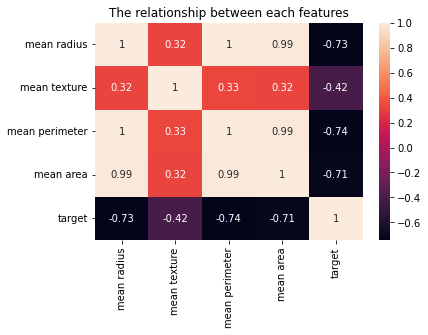

In [9]:
sns.heatmap(df.corr(), annot=True)
plt.title("The relationship between each features")

## Model Training

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=3) # 데이터 분할

In [11]:
from sklearn.svm import SVC # SVM Classifier
from sklearn.metrics import classification_report


In [12]:
clf = SVC(probability=True) # 분류기 정의, probability 변수는 이후에 AUROC 커브를 그리기 위함.
clf.fit(X_train, y_train) # 분류기 훈련
y_pred = clf.predict(X_test) # 예측값 추론
print(classification_report(y_test, y_pred)) # 결과 리포트

              precision    recall  f1-score   support

           0       0.95      0.84      0.89        68
           1       0.91      0.97      0.94       120

    accuracy                           0.93       188
   macro avg       0.93      0.91      0.92       188
weighted avg       0.93      0.93      0.92       188



### Testing Different Parameter of SVC

In [13]:
clf2 = SVC(kernel="linear", probability=True) # 분류기 정의
clf2.fit(X_train, y_train) # 분류기 훈련
y_pred = clf2.predict(X_test) # 예측값 추론
print(classification_report(y_test, y_pred)) # 결과 리포트

              precision    recall  f1-score   support

           0       0.91      0.94      0.93        68
           1       0.97      0.95      0.96       120

    accuracy                           0.95       188
   macro avg       0.94      0.95      0.94       188
weighted avg       0.95      0.95      0.95       188



### 5Fold Cross Validation
* 실제로 kernel 변경이 정확도 향상에 도움이 있었는지 5폴드 교차검증을 통해 증명

In [14]:
from sklearn.model_selection import cross_val_score

scores1 = cross_val_score(clf, data, target, cv=5)
scores2 = cross_val_score(clf2, data, target, cv=5)

print(f"일반 SVC모델 5폴드 정확도 평균: {np.mean(scores1):.2f}")
print(f"Linear커널 SVC모델 5폴드 정확도 평균: {np.mean(scores2):.2f}")

일반 SVC모델 5폴드 정확도 평균: 0.91
Linear커널 SVC모델 5폴드 정확도 평균: 0.95


# Analysis
* kernel에 따라 성능이 달라지는 것을 확인해볼 수 있음
* 데이터의 형태에 따라서 여러 파라미터를 변경해주어야 한다.
* 유방암 데이터의 경우, 선형적으로 데이터를 분할하면 데이터의 분포를 잘 나눌 수 있기 때문에, 분할 방법을 의미하는 파라미터인 kernel을 변경했을 때, 성능이 올라감을 확인할 수 있었다.

### Analysis1 - Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

label = [
    "Iris-Setosa",
    "Iris-Versicolour",
    "Iris-Virginica",
]


plot = plot_confusion_matrix(clf, # 분류 모델
                             X_test, y_test, # 예측 데이터와 예측값의 정답(y_true)
                             display_labels=label, # 표에 표시할 labels
                             cmap=plt.cm.Blues, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
plot.ax_.set_title('Confusion Matrix')

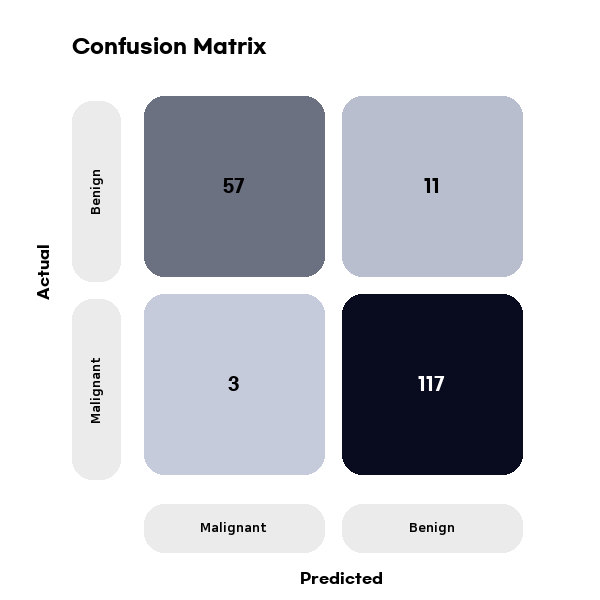

In [15]:
from prettycm import confusion_matrix as p_confusion_matrix
from prettycm import palette
from sklearn.metrics import confusion_matrix


# Define confusion matrix 
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

pcm = p_confusion_matrix(cm)
pcm.set_classname(label_name)
pcm.set_title("Confusion Matrix")

# Define Palette and draw
pset = palette(size=2)
img = pset.draw(pcm, "./L04-pcm.png")
img

### Analysis2 - AUROC Curve
* 1번 모델과 2번 모델 AUROC 커브 비교를 통해 성능을 검증한다.

In [16]:
y_score1 = clf.predict_proba(X_test)[:, 1]
y_score2 = clf2.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_curve
fpr_model1, tpr_model1, _ = roc_curve(y_test, y_score1) # 모델1에 대한 roc_curve 계산 
fpr_model2, tpr_model2, _ = roc_curve(y_test, y_score2) # 모델2에 대한 roc_curve 계산 


ns_probs = [0 for _ in range(len(y_test))] # 기준선을 그리기 위해 모든 확률이 0인 데이터를 생성
fpr_none, tpr_none, _  = roc_curve(y_test, ns_probs) # 기준선에 대한 roc_curve 계산


plt.plot(fpr_none, tpr_none, linestyle='--', label='No Skill')
plt.plot(fpr_model1, tpr_model1, marker='.', label='SVC-No Parameter')
plt.plot(fpr_model2, tpr_model2, marker='.', label='Model-Kernel: Linear')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import roc_curve
fpr_model1, tpr_model1, _ = roc_curve(y_test, y_score1) # 모델1에 대한 roc_curve 계산 
fpr_model2, tpr_model2, _ = roc_curve(y_test, y_score2) # 모델2에 대한 roc_curve 계산 


ns_probs = [0 for _ in range(len(y_test))] # 기준선을 그리기 위해 모든 확률이 0인 데이터를 생성
fpr_none, tpr_none, _  = roc_curve(y_test, ns_probs) # 기준선에 대한 roc_curve 계산


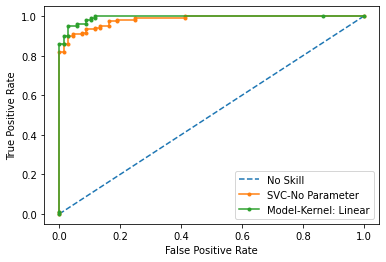

In [18]:
plt.plot(fpr_none, tpr_none, linestyle='--', label='No Skill')
plt.plot(fpr_model1, tpr_model1, marker='.', label='SVC-No Parameter')
plt.plot(fpr_model2, tpr_model2, marker='.', label='Model-Kernel: Linear')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()